# Quick overview

Most of the code presented here is for the Python interface. Transposing the examples to bash should be quite straighforward since commands, options and functionalities should be almost identical between the command line interface and the Python interface. 

## Introduction
The Copernicus Marine Toolbox is a free, user-friendly tool designed to facilitate seamless interaction with the [Copernicus Marine Data Store](https://data.marine.copernicus.eu/products). It offers both a Command Line Interface (CLI) and a Python Application Programming Interface (API), enabling users to efficiently access and manipulate marine data.

One way to access this data is through a visualization tool:  [My Ocean Pro](https://data.marine.copernicus.eu/viewer/expert).

The Copernicus Marine Toolbox allows access to this data programmatically and in an automated way, facilitating the download and distribution. Three of the main resources available are these ones:
- [GitHub](https://github.com/mercator-ocean/copernicus-marine-toolbox): the package repository
- [Documentation](https://toolbox-docs.marine.copernicus.eu/): self-versioned documentation
- [Help Center](https://help.marine.copernicus.eu/en/collections/9080063-copernicus-marine-toolbox): additional information and use cases


The main functions are:
- **Login**: for authentication
- **Describe**: to get metadata from the Data Store
- **Get**: to download original data
- **Subset**: to extract specific portions of datasets by defining variables, geographical areas, time ranges and depth ranges

These four commands are available in a terminal (Command Line Interface) or within a script/notebook (Python API).


## Installation

There are different ways to install the Copernicus Marine Toolbox, using the **`pip`** command, **`mamba | conda`**, the docker image or the binaries. You can see more information in the [installation page](installation-page) of the documentation.

### Check the installation
To verify that it has been installed correctly, we can import the package from Python (or from the CLI) and see if it works properly.

In [ ]:
import copernicusmarine
copernicusmarine.__version__

2.0.0


Once the package is installed, we can start to explore everything the Toolbox has to offer.

## Copernicus Marine Toolbox - Login

The `login` function allows to save credentials and needs to be run only once. Then you can use the rest of the functionalities without specifying your credentials anymore.

To register, you can obtain credentials for free by creating an account at [Copernicus Marine website](https://data.marine.copernicus.eu/register).

For more information, see the [page about login](login-page) of the documentation. You can also check the dedicated pages for the [command line interface](cli-login) or the {func}`Python interface <copernicusmarine.login>`.

Your credentials will be encoded and saved at `~/.copernicusmarine/.copernicusmarine-credentials`. You can change the folder using the `configuration_file_directory` argument.

In [ ]:
# With the Python interface
copernicusmarine.login(username='<your_username>', password='<your_password>')

You can also set environment variables for your processes, they are going be read by the `copernicusmarine.get` and `copernicusmarine.subset` automatically.

In [ ]:
# for Jupyter Notebook
%env COPERNICUSMARINE_SERVICE_USERNAME=<your_username>
%env COPERNICUSMARINE_SERVICE_PASSWORD=<your_password>

# for Python script
import os
os.environ['COPERNICUSMARINE_SERVICE_USERNAME'] = '<your_username>'
os.environ['COPERNICUSMARINE_SERVICE_PASSWORD'] = '<your_password>'

# for cli
!export COPERNICUSMARINE_SERVICE_USERNAME=<your_username>
!export COPERNICUSMARINE_SERVICE_PASSWORD=<your_password>

## Copernicus Marine Toolbox - Describe

The `describe` function allows to explore the catalogue of products and datasets available in Copernicus Marine service. 
In the Python interface, it returns the {class}`copernicusmarine.CopernicusMarineCatalogue` object.

For more information, see the [page about describe](describe-page) of the documentation. You can also check the dedicated pages for the [command line interface](cli-describe) or the {func}`Python interface <copernicusmarine.describe>`.

In [2]:
# by default, we only get information about the products
catalogue = copernicusmarine.describe()

# Let's show the product only doing some filtering
# the copernicusmarine.CopernicusMarineCatalogue oject is a BaseModel object
# see https://docs.pydantic.dev/latest/concepts/models/
# you can easily dump the object to json or dict
catalogue_dict = catalogue.model_dump(
    exclude_none=True, 
    exclude_unset=True, 
    exclude={"products": {"__all__": {"datasets": True, "description": True, "keywords": True}}}
    )
catalogue_dict["products"][0]

Fetching catalogue: 100%|██████████| 2/2 [00:11<00:00,  5.58s/it]


{'title': 'Antarctic Sea Ice Extent from Reanalysis',
 'product_id': 'ANTARCTIC_OMI_SI_extent',
 'thumbnail_url': 'https://catalogue.marine.copernicus.eu/documents/IMG/ANTARCTIC_OMI_SI_extent.png',
 'digital_object_identifier': '10.48670/moi-00186',
 'sources': ['Numerical models'],
 'production_center': 'Mercator Océan International'}

In [3]:
# We can also filter based on the strings found by the describe method
catalogue = copernicusmarine.describe(contains=["Iberian Biscay"])
catalogue.model_dump(
    exclude_none=True, 
    exclude_unset=True, 
    include={"products": {"__all__": {"title": True, "product_id": True, "description": True}}}
    )

Fetching catalogue: 100%|██████████| 2/2 [00:11<00:00,  5.71s/it]


{'products': [{'title': 'Atlantic-Iberian Biscay Irish- Ocean Biogeochemical Analysis and Forecast',
   'product_id': 'IBI_ANALYSISFORECAST_BGC_005_004',
   'description': 'The IBI-MFC provides a high-resolution biogeochemical analysis and forecast product covering the European waters, and more specifically the Iberia–Biscay–Ireland (IBI) area. The last 2 years before now (historic best estimates) as well as daily averaged forecasts with a horizon of 10 days (updated on a weekly basis) are available on the catalogue.\nTo this aim, an online coupled physical-biogeochemical operational system is based on NEMO-PISCES at 1/36° and adapted to the IBI area, being Mercator-Ocean in charge of the model code development. PISCES is a model of intermediate complexity, with 24 prognostic variables. It simulates marine biological productivity of the lower trophic levels and describes the biogeochemical cycles of carbon and of the main nutrients (P, N, Si, Fe).\nThe product provides daily and monthl

Here is an example of a more exhaustive search:

In [ ]:
# For a little more advanced search...
variables = ["chl", "o2"]
regions = ["Iberian Biscay"]

# We find the products that offer the variables we are interested in:
describe_varriable = copernicusmarine.describe(contains=[variables[0], variables[1]])
prod_variable = []
for product in describe_varriable.products:
    prod_variable.append(product.product_id)
print(f"Products that offer the variables {variables}: {len(prod_variable)}")

# We save the products that offer the region we are interested in:
describe_location = copernicusmarine.describe(contains=[regions[0]])
prod_location = []
for product in describe_location.products:
    prod_location.append(product.product_id)
print(f"Products in the region {regions}: {len(prod_location)}")

# And we search the intersection of both lists:
products = [prod_variable, prod_location]
final_selected_products = set.intersection(*map(set,products))

pairs_dataset_step = {}

for product in describe_location.products:
    # We add a filter to clarify specific products, in this case the "OMI" (Ocean Monitoring Indicators)
        if product.product_id in final_selected_products and "OMI_" not in product.product_id:
            for dataset in product.datasets:
                for version in dataset.versions:
                    for part in version.parts:
                        for part in version.parts:
                            for service in part.services[:-1]:
                            # And we filter the datasets that can be subsetted:
                                if 'arco-' in service.service_name and 'zarr' == service.service_format:
                                    for variable in service.variables:
                                        if (variable.short_name == variables[0], variable.short_name == variables[1]) and variable.coordinates != []:
                                            pairs_dataset_step[dataset.dataset_id] = (product.product_id, variable.coordinates[2].step)

for key, value in pairs_dataset_step.items():
    print("______________________")
    print(f"Product: {value[0]}")
    print(f"Dataset: {key}")
    print(f"Spatial resolution : {value[1]}")

Fetching catalogue: 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


Products that offer the variables ['chl', 'o2']: 93


Fetching catalogue: 100%|██████████| 2/2 [00:11<00:00,  5.58s/it]


Products in the region ['Iberian Biscay']: 9
______________________
Product: IBI_ANALYSISFORECAST_BGC_005_004
Dataset: cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m
Spatial resolution : 0.027777777777777776
______________________
Product: IBI_ANALYSISFORECAST_BGC_005_004
Dataset: cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1M-m
Spatial resolution : 0.027777777777777776
______________________
Product: IBI_MULTIYEAR_BGC_005_003
Dataset: cmems_mod_ibi_bgc_my_0.083deg-3D-climatology_P1M-m
Spatial resolution : 0.08333333333333333
______________________
Product: IBI_MULTIYEAR_BGC_005_003
Dataset: cmems_mod_ibi_bgc_my_0.083deg-3D_P1D-m
Spatial resolution : 0.08333333333333333
______________________
Product: IBI_MULTIYEAR_BGC_005_003
Dataset: cmems_mod_ibi_bgc_my_0.083deg-3D_P1M-m
Spatial resolution : 0.08333333333333333
______________________
Product: IBI_MULTIYEAR_BGC_005_003
Dataset: cmems_mod_ibi_bgc_my_0.083deg-3D_P1Y-m
Spatial resolution : 0.08333333333333333


We see that Copernicus Marine has 2 high-resolution products (models) that cover the Bay of Biscay, both for chlorophyll and dissolved oxygen:
- [IBI_ANALYSISFORECAST_BGC_005_004](https://data.marine.copernicus.eu/product/IBI_ANALYSISFORECAST_BGC_005_004/description) with recent data and a few days of forecast
- [IBI_MULTIYEAR_BGC_005_003](https://data.marine.copernicus.eu/product/IBI_MULTIYEAR_BGC_005_003/description) with several years of data covering the last decades

Both products offer daily (`P1D`) and monthly (`P1M`) data. 

Now that we know the productID that are of interest to us, we can directly use `describe` for this product. The process will be way faster since we do not have to parse the whole catalogue. 

In [6]:
product_describe = copernicusmarine.describe(product_id="IBI_MULTIYEAR_BGC_005_003")

# let's only show basic product info
product_describe.model_dump(
    exclude_none=True, 
    exclude_unset=True, 
    exclude={"products": {"__all__": {"datasets": True, "description": True, "keywords": True}}}
    )

Fetching catalogue: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]


{'products': [{'title': 'Atlantic-Iberian Biscay Irish- Ocean BioGeoChemistry NON ASSIMILATIVE Hindcast',
   'product_id': 'IBI_MULTIYEAR_BGC_005_003',
   'thumbnail_url': 'https://mdl-metadata.s3.waw3-1.cloudferro.com/metadata/thumbnails/IBI_MULTIYEAR_BGC_005_003.jpg',
   'digital_object_identifier': '10.48670/moi-00028',
   'sources': ['Numerical models'],
   'processing_level': 'Level 4',
   'production_center': 'NOLOGIN'}]}

## Copernicus Marine Toolbox - Subset

The `subset` function allows to retrieve an extract of the dataset of interest, selecting specific variables, geographical areas, time ranges and depth ranges.

For more information, see the [page about subset](subset-page) of the documentation. You can also check the dedicated pages for the [command line interface](cli-subset) or the {func}`Python interface <copernicusmarine.subset>`.

The `subset` feature is a powerful tool that leverages the capabilities of Copernicus Marine services. It provides access to the entire catalogue and enables precise data selection through two optimized services:
- ARCO Geo Series: ideal for retrieving spatial data over broad areas within short time frames
- ARCO Time Series: suited for extracting temporal data over extended periods in specific, localized regions

These services enhance data retrieval efficiency by tailoring the process to your specific spatial and temporal requirements.


In [ ]:
response_default_service = copernicusmarine.subset(
    dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
    variables=["chl", "o2"],
    maximum_longitude=-3,  
    minimum_longitude=-5,  
    minimum_latitude=43,   
    maximum_latitude=44,
    start_datetime="2023-09-01", end_datetime="2023-09-30", 
    file_format="netcdf",
    output_directory="data",
) 

INFO - 2024-12-16T16:55:21Z - Selected dataset version: "202411"
INFO - 2024-12-16T16:55:21Z - Selected dataset part: "default"
INFO - 2024-12-16T16:55:24Z - Starting download. Please wait...


  0%|          | 0/800 [00:00<?, ?it/s]

INFO - 2024-12-16T16:55:32Z - Successfully downloaded to data/cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m_chl-o2_5.00W-3.03W_43.03N-44.00N_0.49-5727.92m_2023-09-01-2023-09-30.nc


The toolbox tries to select the optimal service for the request to be as efficient as possible. In this case for example, `arco-time-series` has been used by default.

Let’s try to use the other service `arco-geo-series` to see the difference:

In [2]:
response = copernicusmarine.subset(
    dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
    variables=["chl", "o2"],
    maximum_longitude=-3,  
    minimum_longitude=-5,  
    minimum_latitude=43,   
    maximum_latitude=44,
    start_datetime="2023-09-01", end_datetime="2023-09-30", 
    file_format="netcdf",
    output_directory="data",
    dry_run=True, # Run without downloading anything
    service="arco-geo-series"
) 

print(f"arco-geo-series  would download a maximum {response.data_transfer_size} B of data")
print(f"arco-time-series would download a maximum {response_default_service.data_transfer_size} B of data")
# we can see that in this case, the arco-time-series is way more efficient (~10 times less data to download) for the same result

INFO - 2024-12-16T16:56:11Z - Selected dataset version: "202411"
INFO - 2024-12-16T16:56:11Z - Selected dataset part: "default"


arco-geo-series  would download a maximum 10751.198473282442 B of data
arco-time-series would download a maximum 970.8458015267175 B of data


This downloaded file will be stored in the indicated local directory (or in the default one if none is specified). It can be downloaded in NetCDF (`.nc`) or Zarr (`.zarr`) format (more info in [this article](https://help.marine.copernicus.eu/en/articles/8176692-how-to-choose-between-netcdf-and-zarr-format-using-the-toolbox)).

It can then be opened and used with the preferred method (in Python, Matlab, etc.) or software, such as [Panoply](https://www.giss.nasa.gov/tools/panoply/) and [QGIS](https://qgis.org/).

## Copernicus Marine Toolbox - Open Dataset & Read Dataframe
While the four primary functions —`login`, `describe`, `subset`, and `get`— are accessible via both the Command Line Interface (CLI) and the Python API, the Python package further enhances functionality by offering additional features:
- `open_dataset()`: facilitates the loading of xarray datasets using lazy-loading mode, optimizing memory usage by loading data only upon computation
- `read_dataframe()`: enables immediate loading of data into a Pandas dataframe, allowing for efficient data manipulation and analysis

For more information, you can check the dedicated pages for the {func}`open_dataset <copernicusmarine.open_dataset>` function or the {func}`read_dataframe <copernicusmarine.read_dataframe>` function.


### General Dataset
We can view the data of the entire dataset:

In [3]:
# We open the dataset to explore the data:
data = copernicusmarine.open_dataset(dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m")
data

INFO - 2024-12-16T16:57:09Z - Selected dataset version: "202411"
INFO - 2024-12-16T16:57:09Z - Selected dataset part: "default"


<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 1078, longitude: 871, time: 760)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float64 26.17 26.19 26.22 26.25 ... 56.03 56.06 56.08
  * longitude  (longitude) float64 -19.08 -19.06 -19.03 ... 5.029 5.057 5.085
  * time       (time) datetime64[ns] 2022-11-23 2022-11-24 ... 2024-12-21
Data variables: (12/14)
    chl        (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
    dissic     (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
    fe         (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
    nh4        (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
    no3        (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
    nppv       (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
    ...         ...
    phyc       (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
    po4        (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
    si         (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
    spco2      (time, latitude, longitude) float32 dask.array<chunksize=(50, 1078, 871), meta=np.ndarray>
    zeu        (time, latitude, longitude) float32 dask.array<chunksize=(50, 1078, 871), meta=np.ndarray>
    zooc       (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 1078, 871), meta=np.ndarray>
Attributes:
    title:        Biogeochemical 3D daily mean fields for the Iberia-Biscay-I...
    comment:      
    references:   http://marine.copernicus.eu/
    institution:  NOW Systems (Spain)
    contact:      https://marine.copernicus.eu/contact
    source:       NEMO3.6-PISCES3.6
    Conventions:  CF-1.8

The `open_dataset` function uses a lot of the subset functionalities to help you select the data directly and open lazily a dataset. You can also process the data using directly xarray (cf. [xarray documentation](https://docs.xarray.dev/en/stable/)).

In [4]:
import datetime
# Now we can focus on the paraeteers that we are interested in: the region of Cantabria, with a specific dates.
response_bay = copernicusmarine.open_dataset(dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
                        variables=["chl", "o2"],
                        maximum_longitude=-3,  # Sopela, to the right
                        minimum_longitude=-5,  # Llanes, to the left
                        minimum_latitude=43,   # 85km inside the sea
                        maximum_latitude=44,   # Santander
                        start_datetime=datetime.datetime.now()-datetime.timedelta(days=2), 
                        end_datetime=datetime.datetime.now()+datetime.timedelta(days=4))
response_bay

INFO - 2024-12-16T16:57:24Z - Selected dataset version: "202411"
INFO - 2024-12-16T16:57:24Z - Selected dataset part: "default"


<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 36, longitude: 72, time: 6)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float64 43.03 43.05 43.08 43.11 ... 43.94 43.97 44.0
  * longitude  (longitude) float64 -4.999 -4.971 -4.944 ... -3.082 -3.055 -3.027
  * time       (time) datetime64[ns] 2024-12-15 2024-12-16 ... 2024-12-20
Data variables:
    chl        (time, depth, latitude, longitude) float32 dask.array<chunksize=(6, 2, 36, 5), meta=np.ndarray>
    o2         (time, depth, latitude, longitude) float32 dask.array<chunksize=(6, 2, 36, 5), meta=np.ndarray>
Attributes:
    title:        Biogeochemical 3D daily mean fields for the Iberia-Biscay-I...
    comment:      
    references:   http://marine.copernicus.eu/
    institution:  NOW Systems (Spain)
    contact:      https://marine.copernicus.eu/contact
    source:       NEMO3.6-PISCES3.6
    Conventions:  CF-1.8

In [6]:
# I can not see all the values of the dataset without downloading it
# For the time dimension for example:
response_bay.time.values

array(['2024-12-15T00:00:00.000000000', '2024-12-16T00:00:00.000000000',
       '2024-12-17T00:00:00.000000000', '2024-12-18T00:00:00.000000000',
       '2024-12-19T00:00:00.000000000', '2024-12-20T00:00:00.000000000'],
      dtype='datetime64[ns]')

Let's use `xarray` and `matplotlib` to plot our data:

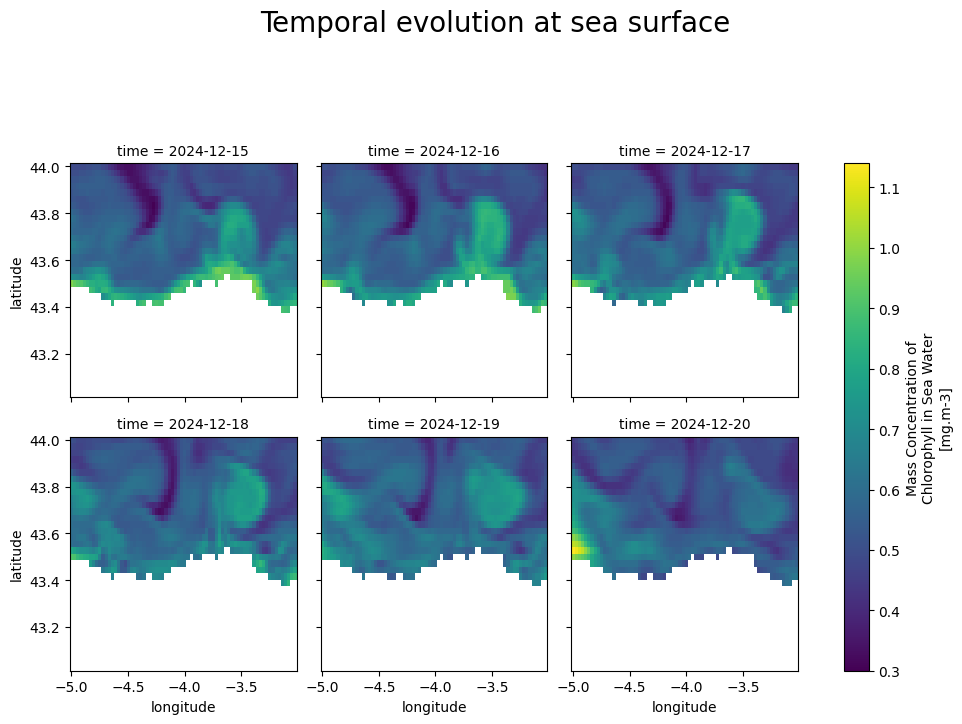

In [5]:
import matplotlib.pyplot as plt

response_bay["chl"].isel(depth=10).plot(col="time", col_wrap=3)
plt.suptitle("Temporal evolution at sea surface", fontsize=20, y=1.2)
plt.show()

## Copernicus Marine Toolbox - Get

The **`get`** function allows to download the original data (i.e. as originally produced).


For more information, see the [page about get](get-page) of the documentation. You can also check the dedicated pages for the [command line interface](cli-get) or the {func}`Python interface <copernicusmarine.get>`.



In [7]:
# Download all the files from a dataset
response_with_all_the_files = copernicusmarine.get(dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", dry_run=True) 

INFO - 2024-12-16T17:00:12Z - Selected dataset version: "202411"
INFO - 2024-12-16T17:00:12Z - Selected dataset part: "default"
INFO - 2024-12-16T17:00:12Z - Listing files on remote server...
1it [00:00,  2.30it/s]


In [10]:
# You can combine the filter and regex argument (it will be as an "OR" condition)
response = copernicusmarine.get(dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
                     filter="*20241221_20241221_R20241212_FC10*", 
                     regex="20241220_20241220_R20241212_FC09", 
                     output_directory="data", # we can specify the output directory
                     overwrite=True, # if files already exist, they will be overwritten
                     )

for file_metadata in response.files:
    print(file_metadata.file_path) 

INFO - 2024-12-16T17:01:44Z - Selected dataset version: "202411"
INFO - 2024-12-16T17:01:44Z - Selected dataset part: "default"
INFO - 2024-12-16T17:01:44Z - Listing files on remote server...
1it [00:00,  2.68it/s]

data/IBI_ANALYSISFORECAST_BGC_005_004/cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m_202411/2024/12/CMEMS_v8r1_IBI_BIO_NRT_NL_01dav_20241220_20241220_R20241212_FC09.nc
data/IBI_ANALYSISFORECAST_BGC_005_004/cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m_202411/2024/12/CMEMS_v8r1_IBI_BIO_NRT_NL_01dav_20241221_20241221_R20241212_FC10.nc


Now if you have downloaded this data, but you want to check if your data is up to date you can use the `sync` option:

In [16]:
response_sync = copernicusmarine.get(
    dataset_id="cmems_mod_ibi_bgc_anfc_0.027deg-3D_P1D-m", 
    filter="*20241221_20241221_R20241212_FC10*", 
    regex="20241220_20241220_R20241212_FC09",  
    dataset_version="202411", 
    output_directory="data",
    sync=True,
    sync_delete=True, # delete the files that are not in the server
    max_concurrent_requests=0, # not in parallel
    # can be useful to be sure to not overload the process 
)

for file_metadata in response_sync.files:
    print(f"Found {file_metadata.filename} on server and it was {file_metadata.file_status}")

INFO - 2024-12-16T17:06:33Z - Selected dataset version: "202411"
INFO - 2024-12-16T17:06:33Z - Selected dataset part: "default"
INFO - 2024-12-16T17:06:33Z - Listing files on remote server...
1it [00:00,  2.64it/s]
INFO - 2024-12-16T17:06:34Z - No data to download


Found CMEMS_v8r1_IBI_BIO_NRT_NL_01dav_20241220_20241220_R20241212_FC09.nc on server and it was IGNORED
Found CMEMS_v8r1_IBI_BIO_NRT_NL_01dav_20241221_20241221_R20241212_FC10.nc on server and it was IGNORED
